In [1]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import pandas as pd
import evaluate
import datasets
import numpy as np
import math
import seaborn as sns
import swifter
import matplotlib.pyplot as plt 
from sklearn import preprocessing

In [2]:
# import data
dataPath = r'C:\Users\17656\Documents\Professional Development\Professional Projects\MBTI NLP\Scripts\\'

trainingData = pd.read_csv(dataPath + "downsampledSecondClean.csv")
trainingData["cleaned"] = trainingData["cleaned"].swifter.apply(lambda x: str(x))
mbtiValues = ["ESTJ", "ESTP", "ESFP", "ESFJ", "ISTJ", "ISTP", "ISFP", "ISFJ", "INTJ", "INTP", "INFP",
              "INFJ", "ENTJ", "ENTP", "ENFP", "ENFJ"]

Pandas Apply:   0%|          | 0/802752 [00:00<?, ?it/s]

Let's preprocess the data to get it ready for application into a dataset

In [3]:
trainingData = trainingData.rename(columns={"flair_text":"label", "cleaned":"text"})
trainingData = trainingData.drop(columns=["body", "length", "labels"])
train, test = train_test_split(trainingData, test_size = 0.20, random_state=123, stratify=trainingData["label"])
print(train["label"].value_counts())
print(test["label"].value_counts())

label
INFJ    40138
INFP    40138
ENFJ    40138
INTJ    40138
ESTP    40138
ESFJ    40138
INTP    40138
ESFP    40138
ENTP    40138
ISFJ    40137
ISTP    40137
ISTJ    40137
ENTJ    40137
ESTJ    40137
ISFP    40137
ENFP    40137
Name: count, dtype: int64
label
ISTP    10035
ENTJ    10035
ISTJ    10035
ISFP    10035
ESTJ    10035
ISFJ    10035
ENFP    10035
INTJ    10034
ESTP    10034
ESFJ    10034
ESFP    10034
INFJ    10034
INFP    10034
ENFJ    10034
ENTP    10034
INTP    10034
Name: count, dtype: int64


In [4]:
featureVals = datasets.Features({"label":datasets.ClassLabel(names=mbtiValues), "text":datasets.Value("string")})

trainDataset = datasets.Dataset.from_dict(train, split="train", features = featureVals)
testDataset = datasets.Dataset.from_dict(test, split="test", features = featureVals)
print("Training Set Size: %d" %train.shape[0])
print("Test Set Size: %d" %test.shape[0])

modelDataset = datasets.DatasetDict({"train":trainDataset, "test":testDataset})

Training Set Size: 642201
Test Set Size: 160551


Now let's get the tokenizer ready for mapping to the data. Let's check text length so we can normalize a bit more

In [5]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [6]:
token_lens = [len(i.split()) for i in train["text"].sample(n=1000)]

C:\Users\17656\.conda\envs\mleng\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


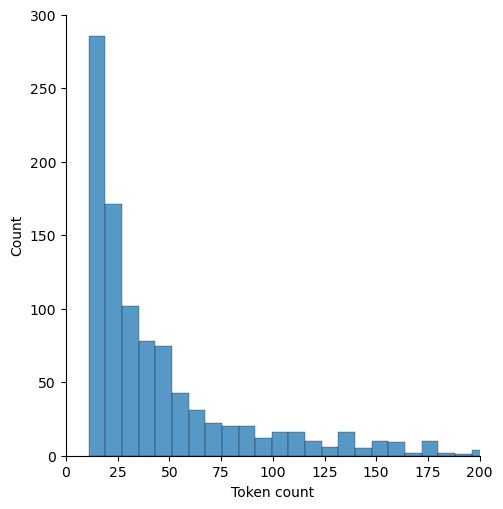

In [7]:
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

Looks like ~175 is a good max length

In [8]:
def tokenizeFunction(examples):
    encoding = tokenizer(
        examples["text"], 
        add_special_tokens = True,
        truncation=True, 
        max_length = 175, 
        pad_to_max_length = True)
    return encoding

In [9]:
encodedDataset = modelDataset.map(tokenizeFunction)

Map:   0%|          | 0/642201 [00:00<?, ? examples/s]

Map:   0%|          | 0/160551 [00:00<?, ? examples/s]

Now let's initialize distilbert

In [18]:
metricToUse = evaluate.load("accuracy")

mbtiList = list(range(0, 16))

id2label = dict(zip(mbtiList, mbtiValues))
label2id = dict(zip(mbtiValues, mbtiList))

print(id2label)
print(label2id)

def metricCompute(evalPred):
    predictions, labels = evalPred
    predictions = np.argmax(predictions, axis=1)
    return metricToUse.compute(predictions = predictions, references = labels)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=16, id2label=id2label, 
                                                           label2id=label2id)

{0: 'ESTJ', 1: 'ESTP', 2: 'ESFP', 3: 'ESFJ', 4: 'ISTJ', 5: 'ISTP', 6: 'ISFP', 7: 'ISFJ', 8: 'INTJ', 9: 'INTP', 10: 'INFP', 11: 'INFJ', 12: 'ENTJ', 13: 'ENTP', 14: 'ENFP', 15: 'ENFJ'}
{'ESTJ': 0, 'ESTP': 1, 'ESFP': 2, 'ESFJ': 3, 'ISTJ': 4, 'ISTP': 5, 'ISFP': 6, 'ISFJ': 7, 'INTJ': 8, 'INTP': 9, 'INFP': 10, 'INFJ': 11, 'ENTJ': 12, 'ENTP': 13, 'ENFP': 14, 'ENFJ': 15}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Create arguments

In [19]:
training_args = TrainingArguments(
    output_dir = "fifthModel_pytorch_imbalancedClass_mbti_10-9-2023",
    learning_rate = 5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=9,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16 = True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encodedDataset["train"],
    eval_dataset=encodedDataset["test"],
    tokenizer=tokenizer,
    compute_metrics=metricCompute
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.509700,2.488496,0.208874
2,2.405900,2.412068,0.235389
3,2.319500,2.380442,0.249647
4,2.240800,2.360672,0.258964
5,2.166300,2.355602,0.266327
6,2.068200,2.350576,0.270481
7,2.050800,2.361028,0.273029
8,2.004300,2.365371,0.275663
9,1.962100,2.372364,0.276298


TrainOutput(global_step=361242, training_loss=2.208303306328221, metrics={'train_runtime': 32631.9566, 'train_samples_per_second': 177.121, 'train_steps_per_second': 11.07, 'total_flos': 2.617574187607848e+17, 'train_loss': 2.208303306328221, 'epoch': 9.0})